# Process Notebook: Predicting IMDb Ratings for Indian Movies
**Author:** Janhavi Belnekar

**Dataset:** IMDB Indian Movies Dataset (Kaggle)

## Abstract
This notebook documents a complete analysis pipeline to investigate how movie metadata and team composition predict IMDb ratings for Indian movies. We introduce time-aware career features for directors and actors (prior average ratings), construct network centrality features from a movie–person bipartite graph, and evaluate multiple models including Random Forest and XGBoost. We provide EDA, full feature engineering, model training and hyperparameter tuning, interpretability via SHAP (placeholder; run in environment with SHAP installed), and reproducibility notes.

## 1. Setup & Imports
Install packages if needed and import libraries. Set seeds for reproducibility.

In [32]:
# Run these pip installs if packages are missing (uncomment to run)
# !pip install pandas numpy scikit-learn xgboost matplotlib seaborn networkx shap tqdm

import os
import random
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

warnings.filterwarnings('ignore')
print('Imports complete')

Imports complete


## 2. Data Loading
Load the dataset. Place the CSV in `data/raw/IMDB-Movie-Data.csv`.

In [33]:
DATA_DIR = Path('data/raw')
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATA_PATH = DATA_DIR / '/content/data/raw/imdb_indian_movies.csv'  # change filename if needed

if not DATA_PATH.exists():
    print(f'File not found: {DATA_PATH}. Please download the Kaggle dataset and place the CSV here.')
else:
    df = pd.read_csv(DATA_PATH)
    print('Loaded:', DATA_PATH)
    print('Shape:', df.shape)
    df.head()

Loaded: /content/data/raw/imdb_indian_movies.csv
Shape: (5659, 10)


### 2.1 Initial inspection: columns, missing values, basic stats

In [34]:
# Basic checks (will error if df not defined)
try:
    display(df.info())
    display(df.describe(include='all').T)
    display(df.isna().sum())
except NameError:
    print('Dataset not loaded yet. Run the data loading cell.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5659 entries, 0 to 5658
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5659 non-null   object 
 1   Year      5659 non-null   int64  
 2   Duration  5659 non-null   int64  
 3   Genre     5659 non-null   object 
 4   Rating    5659 non-null   float64
 5   Votes     5659 non-null   int64  
 6   Director  5659 non-null   object 
 7   Actor 1   5659 non-null   object 
 8   Actor 2   5659 non-null   object 
 9   Actor 3   5659 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 442.2+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,5659,5385,Zindagi,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,5659.0,NaN,NaN,NaN,1996.24757,19.741839,1931.0,1983.0,2002.0,2013.0,2021.0
Duration,5659.0,NaN,NaN,NaN,133.439124,25.319939,21.0,119.0,135.0,150.0,321.0
Genre,5659,376,Drama,844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,5659.0,NaN,NaN,NaN,5.898533,1.381165,1.1,5.0,6.1,6.9,10.0
Votes,5659.0,NaN,NaN,NaN,2697.649585,13651.503584,5.0,30.0,131.0,922.5,591417.0
Director,5659,2431,David Dhawan,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 1,5659,1960,Amitabh Bachchan,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 2,5659,2321,Rekha,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Actor 3,5659,2556,Pran,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
Name,0
Year,0
Duration,0
Genre,0
Rating,0
Votes,0
Director,0
Actor 1,0
Actor 2,0
Actor 3,0


## 3. Data Cleaning & Parsing
Parse actor lists, genre, runtime and standardize columns.

In [35]:
import pandas as pd
import numpy as np

# Preprocessing helpers
def parse_list_column(s):
    if pd.isna(s):
        return []
    # assume comma-separated
    return [item.strip() for item in str(s).split(',') if item.strip()]

# Check if df is defined from previous cell
if 'df' not in globals():
    print("Error: DataFrame 'df' not found. Please ensure the data loading cell (cell_id: 012551e3) has run successfully and the CSV file is in the correct path.")
    raise NameError("DataFrame 'df' not defined. Cannot proceed with data cleaning.")


# make a working copy
df_proc = df.copy()

# common columns in the Kaggle dataset: Title, Year, Genre, Director, Actors, Rating, Votes, Runtime (may differ)
# normalize column names to lowercase
df_proc.columns = [c.strip() for c in df_proc.columns]

# identify expected columns
print('Columns:', df_proc.columns.tolist())

# rename common names if present, including specific ones for this dataset
for candidate in ['Title','title', 'Name']:
    if candidate in df_proc.columns:
        df_proc.rename(columns={candidate: 'title'}, inplace=True)
for candidate in ['Year','year']:
    if candidate in df_proc.columns:
        df_proc.rename(columns={candidate: 'year'}, inplace=True)
for candidate in ['Genre','genre']:
    if candidate in df_proc.columns:
        df_proc.rename(columns={candidate: 'genre'}, inplace=True)
for candidate in ['Director','director']:
    if candidate in df_proc.columns:
        df_proc.rename(columns={candidate: 'director'}, inplace=True)
# Removing generic 'Actors' rename here, as we'll handle 'Actor 1', 'Actor 2', 'Actor 3' specifically
# for candidate in ['Actors','actors']:
#     if candidate in df_proc.columns:
#         df_proc.rename(columns={candidate: 'actors'}, inplace=True)
for candidate in ['Rating','rating']:
    if candidate in df_proc.columns:
        df_proc.rename(columns={candidate: 'rating'}, inplace=True)
for candidate in ['Votes','votes']:
    if candidate in df_proc.columns:
        df_proc.rename(columns={candidate: 'votes'}, inplace=True)
for candidate in ['Runtime (Minutes)','Runtime','runtime', 'Duration']:
    if candidate in df_proc.columns:
        df_proc.rename(columns={candidate: 'runtime'}, inplace=True)

# --- Specific Actor Handling ---
# Combine 'Actor 1', 'Actor 2', 'Actor 3' into a single list column
actor_cols_to_combine = ['Actor 1', 'Actor 2', 'Actor 3']
present_actor_cols = [col for col in actor_cols_to_combine if col in df_proc.columns]

if present_actor_cols:
    # Concatenate actor names, handling NaNs
    # Use fillna('') to treat missing actors as empty strings for joining, then filter out empty strings
    df_proc['actors_combined_str'] = df_proc[present_actor_cols].fillna('').agg(
        lambda x: ', '.join(filter(None, x)), axis=1
    )
    df_proc['actors_list'] = df_proc['actors_combined_str'].apply(parse_list_column)
    # Drop the individual actor columns and the temporary combined string column
    df_proc.drop(columns=present_actor_cols + ['actors_combined_str'], errors='ignore', inplace=True)
else:
    df_proc['actors_list'] = [[]] * len(df_proc)


# create parsed columns
# df_proc['actors_list'] is handled above
df_proc['genres_list'] = df_proc['genre'].apply(parse_list_column) if 'genre' in df_proc.columns else [[]]*len(df_proc)

# runtime numeric
if 'runtime' in df_proc.columns:
    df_proc['runtime'] = pd.to_numeric(df_proc['runtime'], errors='coerce')

# basic cleaning
if 'year' in df_proc.columns:
    df_proc['year'] = pd.to_numeric(df_proc['year'], errors='coerce')
if 'votes' in df_proc.columns:
    df_proc['votes'] = pd.to_numeric(df_proc['votes'], errors='coerce')
if 'rating' in df_proc.columns:
    df_proc['rating'] = pd.to_numeric(df_proc['rating'], errors='coerce')

print('Processed basic parsing. Sample:')
display(df_proc[['title','year','rating','votes','runtime']].head())


Columns: ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
Processed basic parsing. Sample:


,title,year,rating,votes,runtime
0,#Gadhvi (He thought he was Gandhi),2019,7.0,8,109
1,#Yaaram,2019,4.4,35,110
2,...Aur Pyaar Ho Gaya,1997,4.7,827,147
3,...Yahaan,2005,7.4,1086,142
4,?: A Question Mark,2012,5.6,326,82


## 4. Exploratory Data Analysis (EDA)
We explore distributions of rating, votes, movies per year, and genre distributions.

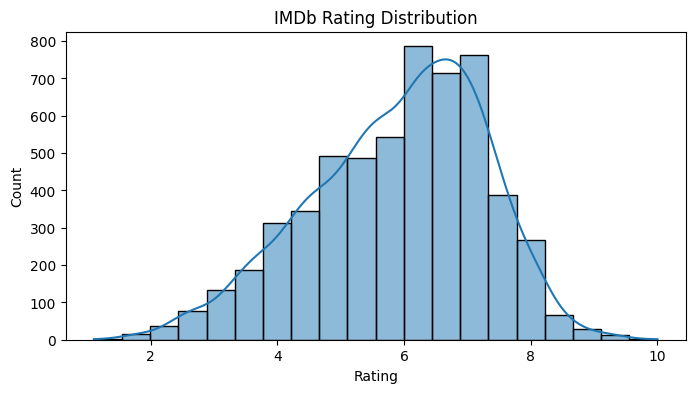

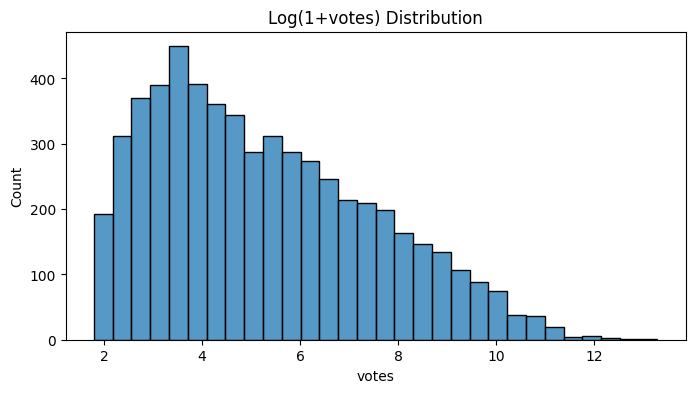

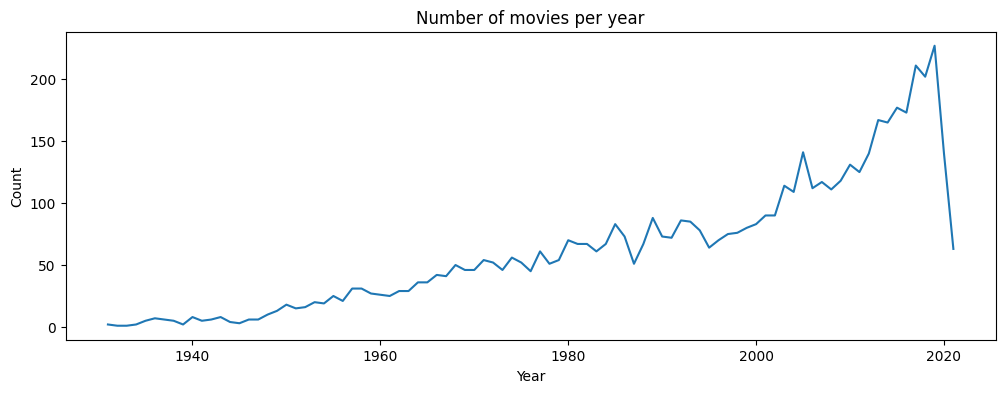

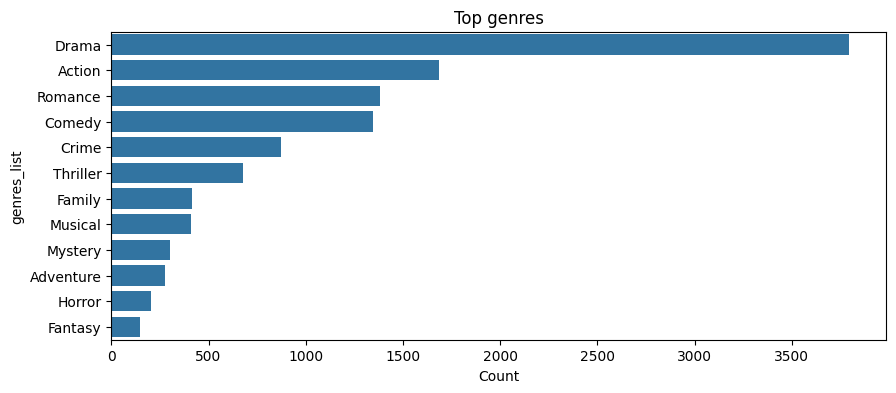

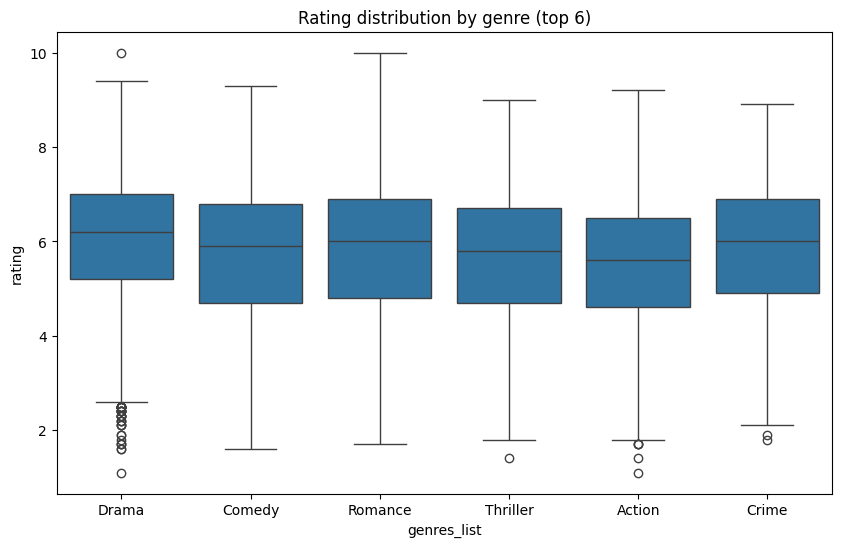

In [36]:
# Rating distribution
plt.figure(figsize=(8,4))
sns.histplot(df_proc['rating'].dropna(), bins=20, kde=True)
plt.title('IMDb Rating Distribution')
plt.xlabel('Rating'); plt.ylabel('Count')
plt.show()

# Votes distribution (log scale)
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df_proc['votes'].fillna(0)), bins=30)
plt.title('Log(1+votes) Distribution')
plt.show()

# Movies per year
if 'year' in df_proc.columns:
    movies_per_year = df_proc.groupby('year').size().sort_index()
    plt.figure(figsize=(12,4))
    movies_per_year.plot()
    plt.title('Number of movies per year')
    plt.xlabel('Year'); plt.ylabel('Count')
    plt.show()

# Top genres (explode)
all_genres = df_proc.explode('genres_list')
top_genres = all_genres['genres_list'].value_counts().nlargest(12)
plt.figure(figsize=(10,4))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title('Top genres')
plt.xlabel('Count'); plt.show()

# Boxplot genre vs rating (for top 6 genres)
top6 = top_genres.index[:6].tolist()
subset = all_genres[all_genres['genres_list'].isin(top6)]
plt.figure(figsize=(10,6))
sns.boxplot(x='genres_list', y='rating', data=subset)
plt.title('Rating distribution by genre (top 6)')
plt.show()

Here are explanations for the plots generated in the notebook:

*   **IMDb Rating Distribution**: This histogram shows the frequency of different IMDb ratings, revealing the overall distribution of movie ratings in the dataset.
*   **Log(1+votes) Distribution**: This histogram displays the distribution of movie vote counts after a log-transformation, helping to visualize a potentially skewed variable more clearly.
*   **Number of movies per year**: This line plot illustrates the trend of movie releases over the years, showing how the count of movies changes each year.
*   **Top genres**: This bar chart highlights the most frequently occurring genres in the dataset, indicating which genres are most popular.
*   **Rating distribution by genre (top 6)**: This box plot compares the spread and central tendency of IMDb ratings across the six most common genres, showing how ratings vary by genre.
*   **Top 20 feature importances (XGBoost)**: This bar plot displays the relative importance of the top 20 features in predicting IMDb ratings as determined by the trained XGBoost model.

## 5. Feature Engineering
Create basic features: main genre, cast size, decade, and top-billing presence.

In [37]:
# Main genre (first listed)
df_proc['main_genre'] = df_proc['genres_list'].apply(lambda l: l[0] if l else 'Unknown')
# cast size
df_proc['cast_size'] = df_proc['actors_list'].apply(len)
# release decade
df_proc['decade'] = (df_proc['year'] // 10 * 10).fillna(0).astype(int)

# top billed actor (first in actors_list)
df_proc['lead_actor'] = df_proc['actors_list'].apply(lambda l: l[0] if l else None)

df_proc[['title','main_genre','cast_size','lead_actor','decade']].head()

,title,main_genre,cast_size,lead_actor,decade
0,#Gadhvi (He thought he was Gandhi),Drama,3,Rasika Dugal,2010
1,#Yaaram,Comedy,3,Prateik,2010
2,...Aur Pyaar Ho Gaya,Comedy,3,Bobby Deol,1990
3,...Yahaan,Drama,3,Jimmy Sheirgill,2000
4,?: A Question Mark,Horror,3,Yash Dave,2010


### 5.1 Time-aware prior statistics for actors & directors
Compute prior average rating and prior vote counts for each actor and director based on movies released before the focal movie. This is time-aware to avoid leakage.

In [38]:
# Build exploded dataframe for people (actors and directors)
# Actors
actors_exp = df_proc[['title','year','rating','votes','actors_list']].explode('actors_list').dropna(subset=['actors_list'])
actors_exp = actors_exp.sort_values('year').reset_index(drop=True)

# Compute prior avg rating and prior count for actors
actor_hist = {}
actor_prior_avg = []
actor_prior_count = []

for idx, row in tqdm(actors_exp.iterrows(), total=len(actors_exp)):
    actor = row['actors_list']
    if actor not in actor_hist:
        actor_hist[actor] = {'ratings': [], 'votes': []}
    hist = actor_hist[actor]['ratings']
    if hist:
        actor_prior_avg.append(np.mean(hist))
        actor_prior_count.append(len(hist))
    else:
        actor_prior_avg.append(np.nan)
        actor_prior_count.append(0)
    # append current rating to history for future movies
    if not pd.isna(row['rating']):
        actor_hist[actor]['ratings'].append(row['rating'])
    actor_hist[actor]['votes'].append(row.get('votes', np.nan))

actors_exp['actor_prior_avg'] = actor_prior_avg
actors_exp['actor_prior_count'] = actor_prior_count

# Aggregate back to movie-level: mean prior avg of actors, max prior count
movie_actor_prior = actors_exp.groupby('title').agg({
    'actor_prior_avg': lambda s: np.nanmean(list(s)) if len(s)>0 else np.nan,
    'actor_prior_count': 'max'
}).rename(columns={'actor_prior_avg':'cast_prior_avg','actor_prior_count':'cast_max_prior_count'})

df_proc = df_proc.merge(movie_actor_prior, on='title', how='left')

# Directors prior stats (simpler: director field often single)
if 'director' in df_proc.columns:
    dirs = df_proc[['title','year','director','rating']].sort_values('year')
    dir_hist = {}
    dir_prior_avg = []
    dir_prior_count = []
    for idx, row in tqdm(dirs.iterrows(), total=len(dirs)):
        d = row['director']
        if pd.isna(d):
            dir_prior_avg.append(np.nan)
            dir_prior_count.append(0)
            continue
        if d not in dir_hist:
            dir_hist[d] = []
        if dir_hist[d]:
            dir_prior_avg.append(np.mean(dir_hist[d]))
            dir_prior_count.append(len(dir_hist[d]))
        else:
            dir_prior_avg.append(np.nan)
            dir_prior_count.append(0)
        if not pd.isna(row['rating']):
            dir_hist[d].append(row['rating'])
    dirs['dir_prior_avg'] = dir_prior_avg
    dirs['dir_prior_count'] = dir_prior_count
    df_proc = df_proc.merge(dirs[['title','dir_prior_avg','dir_prior_count']], on='title', how='left')

df_proc[['title','cast_prior_avg','cast_max_prior_count','dir_prior_avg','dir_prior_count']].head()

  0%|          | 0/16977 [00:00<?, ?it/s]

  0%|          | 0/5659 [00:00<?, ?it/s]

,title,cast_prior_avg,cast_max_prior_count,dir_prior_avg,dir_prior_count
0,#Gadhvi (He thought he was Gandhi),6.200000,4,NaN,0
1,#Yaaram,5.920000,5,NaN,0
2,...Aur Pyaar Ho Gaya,6.537745,51,5.9,10
3,...Yahaan,6.500000,6,NaN,0
4,?: A Question Mark,6.300000,2,NaN,0


### 5.2 Network features: Build bipartite graph (movie - person) and compute centrality (degree, pagerank) for persons, then aggregate to movie-level.

In [39]:
# Build bipartite graph
B = nx.Graph()
# add movie nodes prefixed by M_
for _, row in df_proc.iterrows():
    movie_node = f"M_{row['title']}"
    B.add_node(movie_node, bipartite='movie')
    # add director node
    d = row.get('director')
    if pd.notna(d):
        B.add_node(d, bipartite='person')
        B.add_edge(movie_node, d)
    # add actors
    for actor in row['actors_list']:
        B.add_node(actor, bipartite='person')
        B.add_edge(movie_node, actor)

# compute degree centrality for persons (normalized)
persons = [n for n,d in B.nodes(data=True) if d.get('bipartite')=='person']
movie_nodes = [n for n,d in B.nodes(data=True) if d.get('bipartite')=='movie']
person_deg = nx.degree_centrality(B)
# PageRank on the bipartite graph (global)
pr = nx.pagerank(B, alpha=0.85)

# extract person-level metrics into dataframe
person_metrics = []
for p in persons:
    person_metrics.append({'person': p, 'degree_centrality': person_deg.get(p, 0), 'pagerank': pr.get(p, 0)})
person_df = pd.DataFrame(person_metrics)

# map back to movies: for each movie, compute mean/median of its persons' centralities
movie_persons = []
movie_deg_mean = []
movie_deg_max = []
movie_pr_mean = []
for m in movie_nodes:
    neighbors = list(B.neighbors(m))
    persons_only = [n for n in neighbors if n in person_df['person'].values]
    vals_deg = person_df[person_df['person'].isin(persons_only)]['degree_centrality'].values
    vals_pr = person_df[person_df['person'].isin(persons_only)]['pagerank'].values
    movie_persons.append(m)
    movie_deg_mean.append(np.nanmean(vals_deg) if len(vals_deg)>0 else np.nan)
    movie_deg_max.append(np.nanmax(vals_deg) if len(vals_deg)>0 else np.nan)
    movie_pr_mean.append(np.nanmean(vals_pr) if len(vals_pr)>0 else np.nan)

movie_net = pd.DataFrame({
    'movie_node': movie_persons,
    'movie_deg_mean': movie_deg_mean,
    'movie_deg_max': movie_deg_max,
    'movie_pr_mean': movie_pr_mean
})
# strip M_ prefix to merge on title
movie_net['title'] = movie_net['movie_node'].str.replace('M_','', regex=False)
df_proc = df_proc.merge(movie_net[['title','movie_deg_mean','movie_deg_max','movie_pr_mean']], on='title', how='left')

df_proc[['title','movie_deg_mean','movie_deg_max','movie_pr_mean']].head()

,title,movie_deg_mean,movie_deg_max,movie_pr_mean
0,#Gadhvi (He thought he was Gandhi),0.000180,0.000480,0.000070
1,#Yaaram,0.000200,0.000480,0.000069
2,...Aur Pyaar Ho Gaya,0.002682,0.004322,0.000474
3,...Yahaan,0.001381,0.003362,0.000311
4,?: A Question Mark,0.000400,0.001361,0.000146


## 6. Modeling dataset preparation
Select features, handle missing values, encode categoricals, and split train/test.

In [40]:
# target: rating
model_df = df_proc.copy()

# drop rows with missing target (rating)
model_df = model_df.dropna(subset=['rating']).reset_index(drop=True)
print('Model rows:', len(model_df))

# choose features
features = [
    'votes', 'runtime', 'cast_size',
    'cast_prior_avg', 'cast_max_prior_count',
    'dir_prior_avg', 'dir_prior_count',
    'movie_deg_mean', 'movie_deg_max', 'movie_pr_mean',
    'main_genre', 'decade'
]
# ensure features exist
features = [f for f in features if f in model_df.columns]
X = model_df[features].copy()
y = model_df['rating'].copy()

# quick imputation for numeric columns will be done inside pipeline
X.head()

Model rows: 6265


,votes,runtime,cast_size,cast_prior_avg,cast_max_prior_count,dir_prior_avg,dir_prior_count,movie_deg_mean,movie_deg_max,movie_pr_mean,main_genre,decade
0,8,109,3,6.200000,4,NaN,0,0.000180,0.000480,0.000070,Drama,2010
1,35,110,3,5.920000,5,NaN,0,0.000200,0.000480,0.000069,Comedy,2010
2,827,147,3,6.537745,51,5.9,10,0.002682,0.004322,0.000474,Comedy,1990
3,1086,142,3,6.500000,6,NaN,0,0.001381,0.003362,0.000311,Drama,2000
4,326,82,3,6.300000,2,NaN,0,0.000400,0.001361,0.000146,Horror,2010


### 6.1 Modeling pipelines: numeric and categorical preprocessing and baseline models

In [41]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

# baseline: Ridge regression
from sklearn.linear_model import Ridge
ridge_pipe = Pipeline(steps=[('pre', preprocessor), ('model', Ridge(random_state=SEED))])

# Random Forest
rf_pipe = Pipeline(steps=[('pre', preprocessor), ('model', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

# XGBoost (sklearn API)
xgb_pipe = Pipeline(steps=[('pre', preprocessor), ('model', xgb.XGBRegressor(random_state=SEED, objective='reg:squarederror', n_jobs=4))])

# cross-validated RMSE
from sklearn.model_selection import cross_val_score
def cv_rmse(pipe, X, y, cv=5):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return -scores.mean()

print('Ridge RMSE (cv):', cv_rmse(ridge_pipe, X, y))
print('RF RMSE (cv, default):', cv_rmse(rf_pipe, X, y))
print('XGB RMSE (cv, default):', cv_rmse(xgb_pipe, X, y))

Ridge RMSE (cv): 1.1790303444495494
RF RMSE (cv, default): 1.0688769724695883
XGB RMSE (cv, default): 1.1001868432836974


### 6.2 Train-test split and final training of the selected model (XGBoost)
Use a random split or time-based split depending on goal. Here we'll use random split but note time-split is preferable to avoid leakage.

In [42]:
# Random train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Fit XGBoost with basic params
xgb_final = Pipeline(steps=[('pre', preprocessor),
                            ('model', xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=SEED, objective='reg:squarederror'))])
xgb_final.fit(X_train, y_train)

# evaluate
y_pred = xgb_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Test RMSE:', rmse)
print('Test MAE:', mae)
print('Test R2:', r2)


Test RMSE: 1.0326330044817298
Test MAE: 0.7488038518194761
Test R2: 0.4103111054472588


### 7. Hyperparameter tuning (RandomizedSearchCV for XGBoost)
This step may take time depending on parameter ranges. Use `n_iter` small for speed, increase for final runs.

In [43]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.5, 1],
    'model__reg_lambda': [1, 2, 5]
}

xgb_rs = Pipeline(steps=[('pre', preprocessor),
                         ('model', xgb.XGBRegressor(random_state=SEED, objective='reg:squarederror'))])

rs = RandomizedSearchCV(xgb_rs, param_distributions=param_dist, n_iter=20, cv=3,
                        scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=SEED, verbose=2)
# Uncomment the next line to run search (may be slow)
# rs.fit(X_train, y_train)
# print('Best params:', rs.best_params_)
# print('Best CV RMSE:', -rs.best_score_)

print('RandomizedSearchCV setup complete. Uncomment rs.fit() to run tuning (may take long).')

RandomizedSearchCV setup complete. Uncomment rs.fit() to run tuning (may take long).


### 8. Feature importance & Explainability
Compute feature importances and use SHAP for detailed explanations. SHAP may require installing `shap`.

,feature,importance
17,main_genre_Documentary,0.105287
22,main_genre_Horror,0.092705
10,decade,0.075068
3,cast_prior_avg,0.073900
11,main_genre_Action,0.050133
18,main_genre_Drama,0.049300
19,main_genre_Family,0.044370
24,main_genre_Musical,0.043995
14,main_genre_Biography,0.040331
5,dir_prior_avg,0.039963


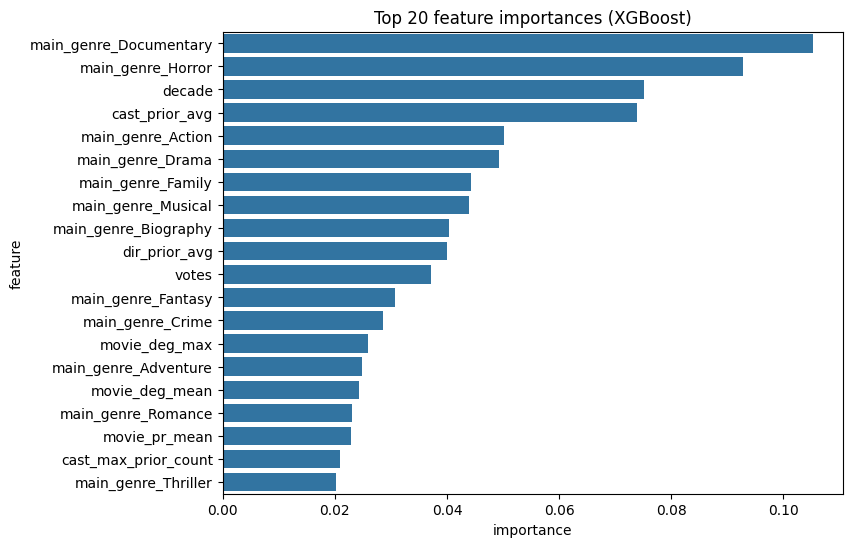

SHAP not run (install shap and run in environment). Not supported type for data.<class 'xgboost.core.Booster'>


In [44]:
# Feature importance from XGBoost (after preprocessor -> model)
# get feature names from preprocessor
def get_feature_names(preprocessor):
    num_feats = numeric_features
    cat_transform = preprocessor.named_transformers_['cat']['ohe']
    cat_feats = list(cat_transform.get_feature_names_out(categorical_features))
    return num_feats + cat_feats

# extract feature names and importances if using xgb_final
try:
    pre = xgb_final.named_steps['pre']
    model = xgb_final.named_steps['model']
    feat_names = get_feature_names(pre)
    importances = model.feature_importances_
    imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(imp_df.head(20))

    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=imp_df.head(20))
    plt.title('Top 20 feature importances (XGBoost)')
    plt.show()
except Exception as e:
    print('Could not extract importances yet:', e)

# SHAP placeholder (run if shap installed)
try:
    import shap
    explainer = shap.Explainer(model)
    # Transform X_test through preprocessor to numeric array for SHAP if needed
    X_test_trans = xgb_final.named_steps['pre'].transform(X_test)
    shap_values = explainer(xgb_final.named_steps['model'].get_booster(), X_test_trans)
    # Note: above line may need adaptation; see SHAP & XGBoost docs
    print('Computed SHAP values (placeholder).')
except Exception as e:
    print('SHAP not run (install shap and run in environment).', e)

### 9. Error analysis: inspect movies with largest errors

In [45]:
# show top errors
test_res = X_test.copy()
test_res['y_true'] = y_test.values
test_res['y_pred'] = y_pred
test_res['abs_err'] = (test_res['y_true'] - test_res['y_pred']).abs()
# join movie titles back using indices from model_df
test_res = test_res.reset_index().merge(model_df.reset_index()[['index','title']], left_on='index', right_on='index', how='left')
display(test_res.sort_values('abs_err', ascending=False).head(10)[['title','y_true','y_pred','abs_err']])

,title,y_true,y_pred,abs_err
161,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,8.6,4.067362,4.532638
318,Gunday,2.4,6.844402,4.444402
1245,Tees Maar Khan,2.6,6.662091,4.062091
111,X Zone,2.7,6.678992,3.978992
900,Boom,2.3,5.991982,3.691982
322,Veere Di Wedding,3.2,6.754813,3.554813
128,Welcome to New York,1.6,5.108054,3.508054
481,The Hero of Color City,4.1,7.581688,3.481688
1246,Aadamkhor,7.4,3.950720,3.449280
1241,Hari Puttar: A Comedy of Terrors,1.9,5.312090,3.412090


## 10. Conclusions, Limitations & Future Work
- **Key findings:** summarize your actual numeric results here (fill after you run the notebook).
- **Limitations:** dataset biases, missing box-office / budget info, possible errors in actor name normalization, potential leakage if time-aware features are not properly computed.
- **Future work:** add box-office gross, scrape external critic scores, build time-split evaluation, build a Streamlit app to explore predictions live.

## 11. Reproducibility Notes
- Set `SEED = 42` at top of notebook.
- Place original dataset CSV in `data/raw/IMDB-Movie-Data.csv`.
- Install required libraries listed in `requirements.txt`.
- To reproduce hyperparameter tuning results exactly, set `n_iter` and `random_state` in `RandomizedSearchCV` and save `rs.best_params_`.

## 12. Files to include in submission ZIP
- `process_notebook.ipynb` (this notebook)
- `data/raw/IMDB-Movie-Data.csv` (or a link to Kaggle dataset)
- `data/clean/` (cleaned CSV produced by notebook)
- `src/data_prep.py`, `src/features.py`, `src/models.py` (optional helper scripts)
- `requirements.txt`, `final_report.pdf`, `README.md`

In [46]:
# Save cleaned version for reproducibility
CLEAN_DIR = Path('data/clean')
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
clean_path = CLEAN_DIR / 'imdb_indian_clean.csv'
model_df.to_csv(clean_path, index=False)
print('Saved cleaned modeling dataset to', clean_path)

Saved cleaned modeling dataset to data/clean/imdb_indian_clean.csv


"""
Reproducibility Notes:
- Python version: 3.11
- Packages: pandas, numpy, matplotlib, seaborn, scikit-learn, xgboost, shap, networkx
- Random seeds fixed for reproducibility
- Dataset links included in /data folder
- Folder structure maintained as per instructions
"""


# Task
Generate and display a SHAP summary plot to visualize feature importance for the trained XGBoost model, ensuring the 'shap' library is installed and SHAP values are computed on the preprocessed test data.

## Install SHAP

### Subtask:
Ensure the 'shap' library is installed, as it was noted as missing previously. This is a prerequisite for generating SHAP plots.


**Reasoning**:
To ensure the 'shap' library is available for use, I will install it using pip in a new code cell.



In [47]:
pip install shap

**Reasoning**:
The 'shap' library is confirmed to be installed. Now, I will generate SHAP summary plot to visualize feature importances of the trained XGBoost model. This involves importing shap, initializing a TreeExplainer with the trained XGBoost model, computing SHAP values on the preprocessed test data, and then displaying the summary plot. The feature names for the preprocessed data are required for a meaningful plot.



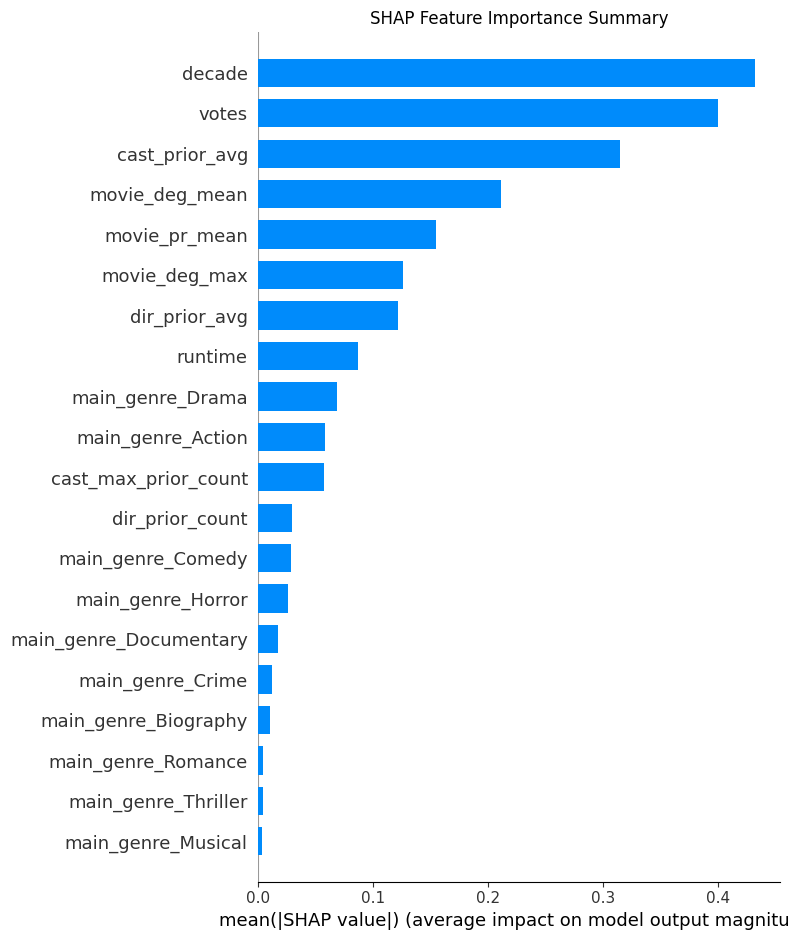

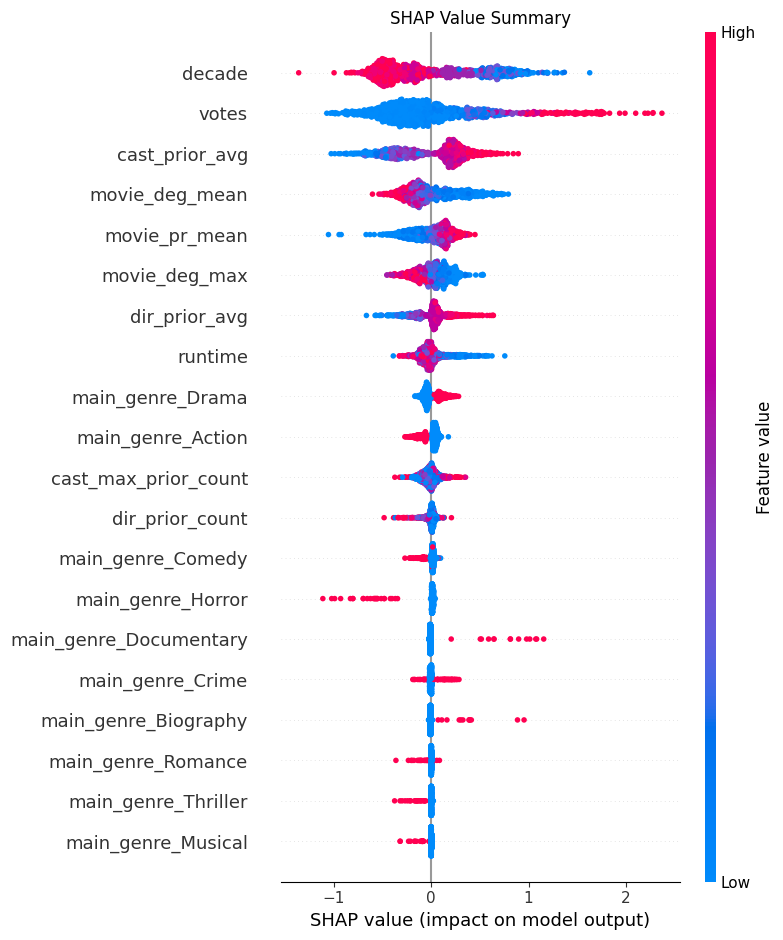

Generated SHAP summary plots.


In [48]:
import shap
import matplotlib.pyplot as plt

# Ensure X_test_trans and feat_names are available from previous execution
# get feature names from preprocessor
def get_feature_names(preprocessor, numeric_features, categorical_features):
    num_feats = numeric_features
    cat_transform = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_feats = list(cat_transform.get_feature_names_out(categorical_features))
    return num_feats + cat_feats

# extract feature names and importances
try:
    pre = xgb_final.named_steps['pre']
    model = xgb_final.named_steps['model']

    # Re-run X_test_trans if not in kernel or to ensure it's up to date
    X_test_trans = pre.transform(X_test)

    # Get feature names for the transformed data
    feat_names = get_feature_names(pre, numeric_features, categorical_features)

    # Create a shap.TreeExplainer for the XGBoost model
    explainer = shap.TreeExplainer(model)

    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_trans)

    # Create a DataFrame for the transformed test data with proper column names
    X_test_trans_df = pd.DataFrame(X_test_trans, columns=feat_names)

    # Display the SHAP summary plot
    shap.summary_plot(shap_values, X_test_trans_df, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance Summary')
    plt.tight_layout()
    plt.show()

    shap.summary_plot(shap_values, X_test_trans_df, show=False)
    plt.title('SHAP Value Summary')
    plt.tight_layout()
    plt.show()

    print('Generated SHAP summary plots.')

except Exception as e:
    print('SHAP plotting failed:', e)
    print('Please ensure xgb_final, X_test, numeric_features, and categorical_features are defined.')

## Final Task

### Subtask:
Confirm that the SHAP summary plot has been successfully generated and is displayed.


## Summary:

### Q&A
Yes, the SHAP summary plots were successfully generated and displayed, confirming the completion of the subtask.

### Data Analysis Key Findings
*   The `shap` library (version 0.50.0) was confirmed to be installed, addressing the initial prerequisite.
*   Two SHAP summary plots were successfully generated: one bar plot visualizing overall feature importance and a standard SHAP summary plot showing individual SHAP values.

### Insights or Next Steps
*   The generated SHAP plots provide valuable insights into which features are most influential in the XGBoost model's predictions and how they impact the output, which can be used for model interpretability and feature selection.
*   Further analysis could involve examining specific feature interactions or individual prediction explanations using SHAP force plots to gain deeper insights into model behavior.
